# All

In [ ]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import random
import numpy as np
import tensorflow as tf
import pandas as pd
! pip install optuna
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
import gdown
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"
output_file = "downloaded_file.xlsx"
gdown.download(download_url, output=output_file, quiet=False)

df = pd.read_excel(output_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
target_column = "Inflation"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Deep learning
import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

for lag in range(1, 10):
    print(f"\nProcessing lag = {lag}...")

    # Sequence generation
    X, y = create_sequences(df[target_column].values, lag)
    split_index = int(len(X) * 0.9)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    def create_model(trial, input_shape):
        model = Sequential()
        model.add(Conv1D(
            filters=trial.suggest_int('filters', 32, 128),
            kernel_size=trial.suggest_int('kernel_size', 1, lag),
            activation='relu',
            input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer=Adam(
            learning_rate=trial.suggest_float('lr', 1e-4, 1e-2, log=True)),
            loss='mse')
        return model

    def objective(trial):
        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []
        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            model = create_model(trial, X_train.shape[1:])
            model.fit(X_t, y_t,
                      epochs=trial.suggest_int('epochs', 10, 50),
                      verbose=0,
                      batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)
        return np.mean(val_losses)

    # Optuna study
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=30)

    best_params = study.best_trial.params

    # Final model training
    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train,
              epochs=best_params['epochs'],
              batch_size=best_params['batch_size'],
              verbose=0)

    # Evaluation
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    results.append({
        "Lag": lag,
        "Best Parameters": best_params,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R²": r2
    })

# Save results to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("CNN_Lag_Performance_Results.xlsx", index=False)
print("\n✅ All lags processed. Results saved to 'CNN_Lag_Performance_Results.xlsx'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.4 MB/s eta 0:00:00


Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 22.8MB/s]
[I 2025-05-30 05:22:46,035] A new study created in memory with name: no-name-9d71d14a-49b1-4117-9972-c5d759fe1c27



Processing lag = 1...


[I 2025-05-30 05:23:01,349] Trial 0 finished with value: 0.0009922955456810694 and parameters: {'filters': 68, 'kernel_size': 1, 'lr': 0.007969454818643935, 'epochs': 40, 'batch_size': 8}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-05-30 05:23:11,612] Trial 1 finished with value: 0.0014993543542611103 and parameters: {'filters': 37, 'kernel_size': 1, 'lr': 0.005399484409787433, 'epochs': 34, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-05-30 05:23:19,007] Trial 2 finished with value: 0.008811166238350173 and parameters: {'filters': 112, 'kernel_size': 1, 'lr': 0.00026587543983272726, 'epochs': 17, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-05-30 05:23:29,181] Trial 3 finished with value: 0.0074224772009377675 and parameters: {'filters': 73, 'kernel_size': 1, 'lr': 0.0003823475224675188, 'epochs': 35, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-05-30 05:23:37,068] Trial 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-30 05:29:28,114] A new study created in memory with name: no-name-5b904476-1a3c-4145-99e7-a730c66b6091



Processing lag = 2...


[I 2025-05-30 05:29:40,591] Trial 0 finished with value: 0.0011528398705801617 and parameters: {'filters': 68, 'kernel_size': 2, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-05-30 05:29:47,001] Trial 1 finished with value: 0.0019050341312928747 and parameters: {'filters': 116, 'kernel_size': 2, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-05-30 05:29:56,881] Trial 2 finished with value: 0.007340384569639961 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-05-30 05:30:08,775] Trial 3 finished with value: 0.0031699159493048987 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-05-30 05:30:16,158] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-05-30 05:35:51,425] A new study created in memory with name: no-name-8e0f54ca-226b-4c91-b2c9-bd7ff976b5ca



Processing lag = 3...


[I 2025-05-30 05:36:05,804] Trial 0 finished with value: 0.0015084827415800344 and parameters: {'filters': 68, 'kernel_size': 3, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-05-30 05:36:12,064] Trial 1 finished with value: 0.0029754152928944677 and parameters: {'filters': 116, 'kernel_size': 2, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-05-30 05:36:22,460] Trial 2 finished with value: 0.005909701692871749 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-05-30 05:36:34,347] Trial 3 finished with value: 0.0037386257705899575 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-05-30 05:36:41,648] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-30 05:42:42,751] A new study created in memory with name: no-name-dc6e3392-81d4-47d6-a42a-09c9daa34fb7



Processing lag = 4...


[I 2025-05-30 05:42:58,497] Trial 0 finished with value: 0.0011705132201313972 and parameters: {'filters': 68, 'kernel_size': 4, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-05-30 05:43:05,232] Trial 1 finished with value: 0.00311851070728153 and parameters: {'filters': 116, 'kernel_size': 3, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-05-30 05:43:15,185] Trial 2 finished with value: 0.010800680068011085 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-05-30 05:43:26,862] Trial 3 finished with value: 0.0029725841401765742 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-05-30 05:43:33,284] Trial 4 f

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-30 05:49:24,428] A new study created in memory with name: no-name-cd2384f5-70fc-49fa-8b6a-51c817ae135a



Processing lag = 5...


[I 2025-05-30 05:49:39,349] Trial 0 finished with value: 0.0010087729218260695 and parameters: {'filters': 68, 'kernel_size': 5, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-05-30 05:49:50,178] Trial 1 finished with value: 0.0023805702997681997 and parameters: {'filters': 116, 'kernel_size': 4, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-05-30 05:50:01,021] Trial 2 finished with value: 0.007866515855615338 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-05-30 05:50:14,343] Trial 3 finished with value: 0.0024021217929354557 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-05-30 05:50:22,298] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-30 05:56:18,227] A new study created in memory with name: no-name-f995007b-c191-45b8-ad9a-9981b984ea4a



Processing lag = 6...


[I 2025-05-30 05:56:32,709] Trial 0 finished with value: 0.001254707477831592 and parameters: {'filters': 68, 'kernel_size': 6, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-05-30 05:56:40,203] Trial 1 finished with value: 0.002082561705416689 and parameters: {'filters': 116, 'kernel_size': 4, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-05-30 05:56:50,354] Trial 2 finished with value: 0.007285374643591543 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-05-30 05:57:02,760] Trial 3 finished with value: 0.0036035726661793888 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-05-30 05:57:09,462] Trial 4 finis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-05-30 06:03:03,751] A new study created in memory with name: no-name-be9cc0c9-9831-4d23-b477-5091e50e007c



Processing lag = 7...


[I 2025-05-30 06:03:18,313] Trial 0 finished with value: 0.0012752100883517414 and parameters: {'filters': 68, 'kernel_size': 7, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-05-30 06:03:24,156] Trial 1 finished with value: 0.0027641780325211585 and parameters: {'filters': 116, 'kernel_size': 5, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-05-30 06:03:33,925] Trial 2 finished with value: 0.006761149658511083 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-05-30 06:03:45,775] Trial 3 finished with value: 0.0033653322219227753 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-05-30 06:03:53,165] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-30 06:09:53,595] A new study created in memory with name: no-name-2cc9765e-4098-49e1-aa20-49d1aeaabd23



Processing lag = 8...


[I 2025-05-30 06:10:07,931] Trial 0 finished with value: 0.001218972179534224 and parameters: {'filters': 68, 'kernel_size': 8, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-05-30 06:10:14,974] Trial 1 finished with value: 0.003234386288871368 and parameters: {'filters': 116, 'kernel_size': 5, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-05-30 06:10:25,019] Trial 2 finished with value: 0.006945732980966568 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-05-30 06:10:36,984] Trial 3 finished with value: 0.004202523016526054 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-05-30 06:10:43,800] Trial 4 finish

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-30 06:16:21,614] A new study created in memory with name: no-name-69c5f90e-ceec-4ade-9cdc-6c514db86ba8



Processing lag = 9...


[I 2025-05-30 06:16:35,392] Trial 0 finished with value: 0.0017530519786911707 and parameters: {'filters': 68, 'kernel_size': 9, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-05-30 06:16:42,992] Trial 1 finished with value: 0.003412353068900605 and parameters: {'filters': 116, 'kernel_size': 6, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-05-30 06:16:52,917] Trial 2 finished with value: 0.008018926988976697 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-05-30 06:17:04,894] Trial 3 finished with value: 0.00380562434050565 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-05-30 06:17:11,124] Trial 4 fi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

✅ All lags processed. Results saved to 'CNN_Lag_Performance_Results.xlsx'


## 1

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 18.9MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.8 MB/s eta 0:00:00


[I 2025-05-29 08:31:48,167] A new study created in memory with name: no-name-96125247-c23a-46e1-a15d-5360b929a8a8
[I 2025-05-29 08:31:58,168] Trial 0 finished with value: 0.012393982848152518 and parameters: {'filters': 61, 'kernel_size': 1, 'lr': 0.00040172087368603595, 'epochs': 14, 'batch_size': 16}. Best is trial 0 with value: 0.012393982848152518.
[I 2025-05-29 08:32:12,302] Trial 1 finished with value: 0.011188046618675193 and parameters: {'filters': 74, 'kernel_size': 1, 'lr': 0.0001481636879844737, 'epochs': 42, 'batch_size': 32}. Best is trial 1 with value: 0.011188046618675193.
[I 2025-05-29 08:32:31,722] Trial 2 finished with value: 0.004563116934150457 and parameters: {'filters': 106, 'kernel_size': 1, 'lr': 0.0001433354289085796, 'epochs': 48, 'batch_size': 8}. Best is trial 2 with value: 0.004563116934150457.
[I 2025-05-29 08:32:42,937] Trial 3 finished with value: 0.0020657130129014454 and parameters: {'filters': 61, 'kernel_size': 1, 'lr': 0.00046128410985696013, 'epoch

Best trial: {'filters': 87, 'kernel_size': 1, 'lr': 0.005260334424782903, 'epochs': 31, 'batch_size': 16}
Epoch 1/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089   
Epoch 2/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 
Epoch 3/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011      
Epoch 4/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9154e-04 
Epoch 5/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5800e-04 
Epoch 6/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3409e-04 
Epoch 7/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9041e-04 
Epoch 8/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0001e-04 
Epoch 9/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4862e-04
Epoch 10/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3059e-04 
Epoch 11/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4683e-04 
Epoch 12/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7530e-04 
Epoch 13/31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

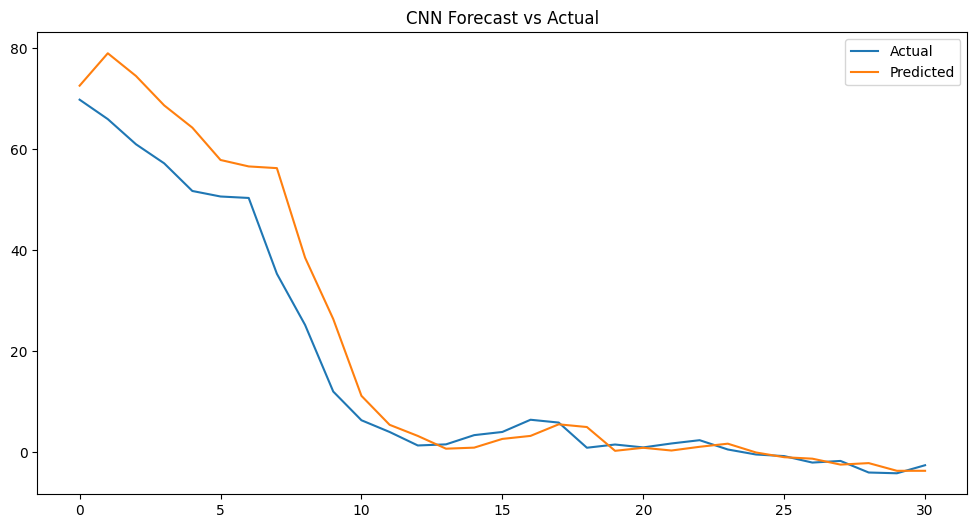

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 1  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 1), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 2

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 12.5MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [ ]:
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 2  # Monthly data (1 year of past data to predict next month)

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)


In [ ]:
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 2),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)


[I 2025-05-29 08:36:55,180] A new study created in memory with name: no-name-67f94eff-e80e-4da3-90a5-d50ac8d0c2d1
[I 2025-05-29 08:37:06,908] Trial 0 finished with value: 0.0014085475559113547 and parameters: {'filters': 116, 'kernel_size': 1, 'lr': 0.007542740434821305, 'epochs': 11, 'batch_size': 16}. Best is trial 0 with value: 0.0014085475559113547.
[I 2025-05-29 08:37:19,534] Trial 1 finished with value: 0.0009573665059482058 and parameters: {'filters': 93, 'kernel_size': 1, 'lr': 0.004927862617555429, 'epochs': 35, 'batch_size': 16}. Best is trial 1 with value: 0.0009573665059482058.
[I 2025-05-29 08:37:28,060] Trial 2 finished with value: 0.0021169115837741024 and parameters: {'filters': 75, 'kernel_size': 2, 'lr': 0.0009990225880974904, 'epochs': 20, 'batch_size': 8}. Best is trial 1 with value: 0.0009573665059482058.
[I 2025-05-29 08:37:38,395] Trial 3 finished with value: 0.0012604730436578393 and parameters: {'filters': 127, 'kernel_size': 2, 'lr': 0.002418421956365958, 'epo

Best trial: {'filters': 62, 'kernel_size': 1, 'lr': 0.005942373996699401, 'epochs': 45, 'batch_size': 16}


In [ ]:
# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


Epoch 1/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112   
Epoch 2/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 3/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 4/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 
Epoch 5/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9469e-04 
Epoch 6/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5482e-04
Epoch 7/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5894e-04 
Epoch 8/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9937e-04  
Epoch 9/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7145e-04 
Epoch 10/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0582e-04 
Epoch 11/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5251e-04 
Epoch 12/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9072e-04 
Epoch 13/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6724e-04
Epoch 14/45
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6856e-04
Epoch 15/45
17/17 ━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Test MSE: 13.6996
Test MAE: 2.5043
Test R2: 0.9765


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
 Test MSE  : 13.6996
 Test RMSE : 3.7013
 Test MAE  : 2.5043
 Test MAPE : 94.48%
 Test R²   : 0.9765


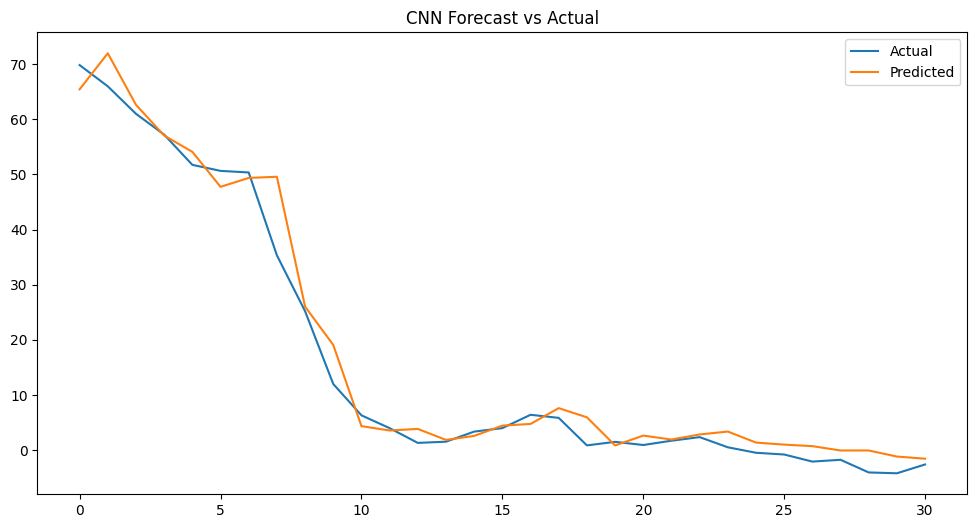

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()


## 3

## *

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 19.9MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 08:42:53,451] A new study created in memory with name: no-name-c68a6d82-7270-4a86-81c9-c0ab52f68d5b
[I 2025-05-29 08:43:04,826] Trial 0 finished with value: 0.0036540544436623654 and parameters: {'filters': 37, 'kernel_size': 3, 'lr': 0.0008049732038795101, 'epochs': 46, 'batch_size': 32}. Best is trial 0 with value: 0.0036540544436623654.
[I 2025-05-29 08:43:11,126] Trial 1 finished with value: 0.008901278100286921 and parameters: {'filters': 39, 'kernel_size': 1, 'lr': 0.000217625046642519, 'epochs': 13, 'batch_size': 16}. Best is trial 0 with value: 0.0036540544436623654.
[I 2025-05-29 08:43:22,663] Trial 2 finished with value: 0.0023884525968848416 and parameters: {'filters': 121, 'kernel_size': 3, 'lr': 0.001800588169531197, 'epochs': 47, 'batch_size': 32}. Best is trial 2 with value: 0.0023884525968848416.
[I 2025-05-29 08:43:33,559] Trial 3 finished with value: 0.0007569780282210559 and parameters: {'filters': 113, 'kernel_size': 2, 'lr': 0.003828457813897878, 'epo

Best trial: {'filters': 98, 'kernel_size': 2, 'lr': 0.00962706360365874, 'epochs': 39, 'batch_size': 8}
Epoch 1/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084   
Epoch 2/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 
Epoch 3/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 4/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9223e-04
Epoch 5/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3154e-04
Epoch 6/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0157e-04
Epoch 7/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7947e-04
Epoch 8/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1994e-04
Epoch 9/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 10/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5635e-04
Epoch 11/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 12/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 13/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 
Epoch 14/39
34/34 

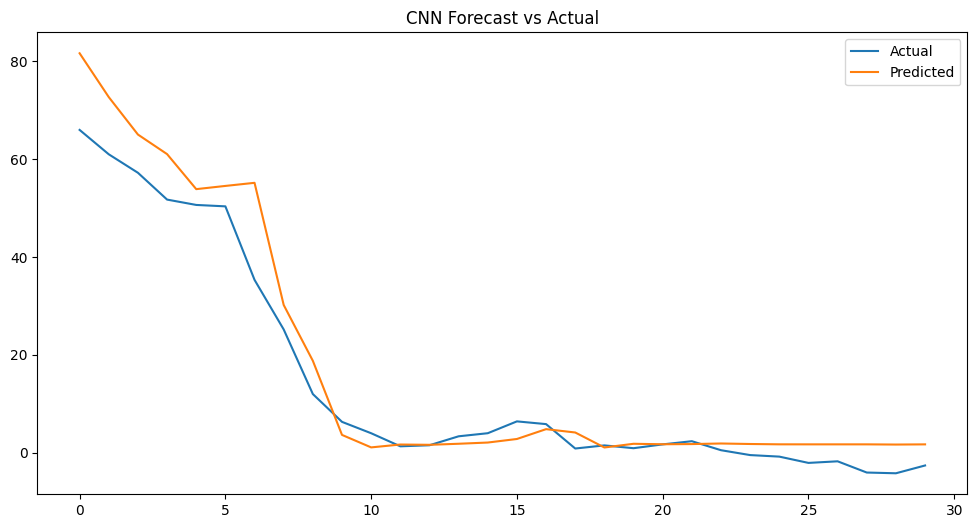

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 3  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 3), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 4

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 22.6MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 08:48:49,775] A new study created in memory with name: no-name-b45b8ec0-cadb-4723-b438-a6197305ac2a
[I 2025-05-29 08:48:58,716] Trial 0 finished with value: 0.0103150166105479 and parameters: {'filters': 76, 'kernel_size': 2, 'lr': 0.0001995634091070124, 'epochs': 32, 'batch_size': 32}. Best is trial 0 with value: 0.0103150166105479.
[I 2025-05-29 08:49:05,320] Trial 1 finished with value: 0.00516133524555092 and parameters: {'filters': 98, 'kernel_size': 3, 'lr': 0.0018867942787103775, 'epochs': 15, 'batch_size': 32}. Best is trial 1 with value: 0.00516133524555092.
[I 2025-05-29 08:49:19,440] Trial 2 finished with value: 0.0028380537987686694 and parameters: {'filters': 81, 'kernel_size': 4, 'lr': 0.00025531974735548956, 'epochs': 45, 'batch_size': 8}. Best is trial 2 with value: 0.0028380537987686694.
[I 2025-05-29 08:49:24,517] Trial 3 finished with value: 0.0032777564289669194 and parameters: {'filters': 69, 'kernel_size': 4, 'lr': 0.00565987895072878, 'epochs': 12, 

Best trial: {'filters': 114, 'kernel_size': 3, 'lr': 0.009113589802220377, 'epochs': 39, 'batch_size': 16}
Epoch 1/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108   
Epoch 2/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 
Epoch 3/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 4/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 5/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 6/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016     
Epoch 7/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
Epoch 8/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4998e-04 
Epoch 9/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013     
Epoch 10/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3398e-04 
Epoch 11/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7423e-04 
Epoch 12/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1404e-04 
Epoch 13/39
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7839e-04 
E

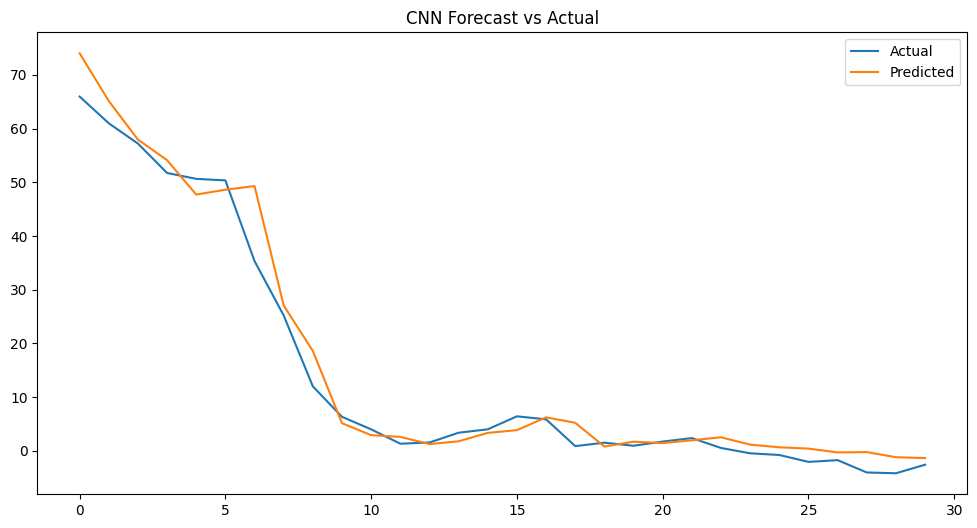

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 4  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 4), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 5

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 23.3MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 08:54:19,746] A new study created in memory with name: no-name-18111b87-5844-4768-be50-a8fa1980135f
[I 2025-05-29 08:54:28,060] Trial 0 finished with value: 0.0015994624506371717 and parameters: {'filters': 94, 'kernel_size': 5, 'lr': 0.004420145776665706, 'epochs': 19, 'batch_size': 8}. Best is trial 0 with value: 0.0015994624506371717.
[I 2025-05-29 08:54:34,072] Trial 1 finished with value: 0.011382675070005158 and parameters: {'filters': 88, 'kernel_size': 4, 'lr': 0.00010728441285091175, 'epochs': 17, 'batch_size': 16}. Best is trial 0 with value: 0.0015994624506371717.
[I 2025-05-29 08:54:41,162] Trial 2 finished with value: 0.008574499127765497 and parameters: {'filters': 86, 'kernel_size': 5, 'lr': 0.00020140527566452684, 'epochs': 16, 'batch_size': 16}. Best is trial 0 with value: 0.0015994624506371717.
[I 2025-05-29 08:54:51,252] Trial 3 finished with value: 0.004465166692777227 and parameters: {'filters': 80, 'kernel_size': 2, 'lr': 0.00041339317405378415, 'epo

Best trial: {'filters': 39, 'kernel_size': 3, 'lr': 0.00622966715240759, 'epochs': 50, 'batch_size': 8}
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036     
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2313e-04 
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3032e-04
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9774e-04
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7809e-04
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6044e-04
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2563e-04 
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7777e-04
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8704e-04
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
 Test MSE  : 27.4257
 Test RMSE : 5.2370
 Test MAE  : 3.9186
 Test MAPE : 108.79%
 Test R²   : 0.9455


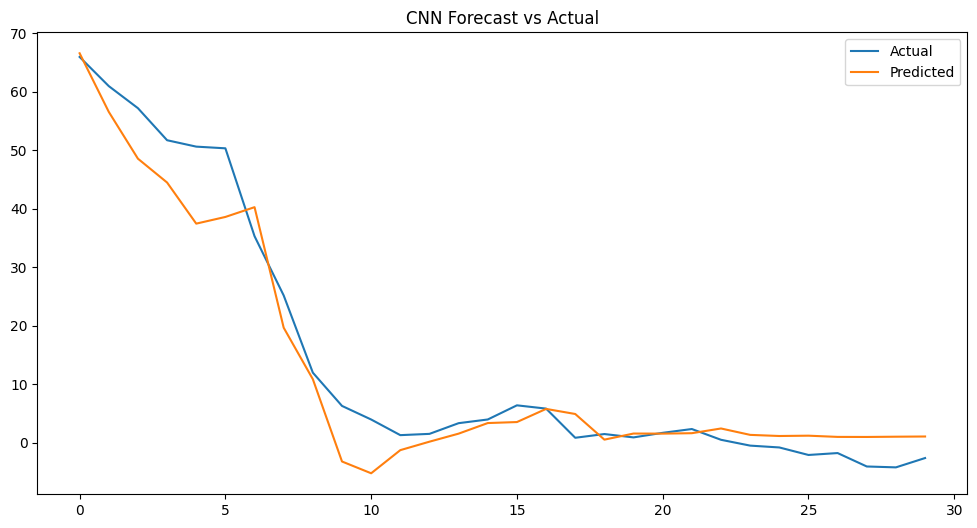

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 5  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 5), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 6

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 9.05MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 09:00:33,209] A new study created in memory with name: no-name-0e8210ee-8c9a-4a5e-b360-65549bd72deb
[I 2025-05-29 09:00:41,423] Trial 0 finished with value: 0.002376804477535188 and parameters: {'filters': 66, 'kernel_size': 3, 'lr': 0.0032455948955015094, 'epochs': 15, 'batch_size': 8}. Best is trial 0 with value: 0.002376804477535188.
[I 2025-05-29 09:00:52,586] Trial 1 finished with value: 0.0024241221738824 and parameters: {'filters': 70, 'kernel_size': 4, 'lr': 0.0012894878214550793, 'epochs': 40, 'batch_size': 16}. Best is trial 0 with value: 0.002376804477535188.
[I 2025-05-29 09:00:58,257] Trial 2 finished with value: 0.016408457420766354 and parameters: {'filters': 86, 'kernel_size': 2, 'lr': 0.00012273917220589442, 'epochs': 15, 'batch_size': 32}. Best is trial 0 with value: 0.002376804477535188.
[I 2025-05-29 09:01:08,702] Trial 3 finished with value: 0.0026427294748524823 and parameters: {'filters': 99, 'kernel_size': 3, 'lr': 0.0009514597322127403, 'epochs': 

Best trial: {'filters': 108, 'kernel_size': 1, 'lr': 0.006451882394047284, 'epochs': 47, 'batch_size': 8}
Epoch 1/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137
Epoch 2/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 3/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 4/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2629e-04
Epoch 5/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 6/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8178e-04
Epoch 7/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7510e-04
Epoch 8/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8601e-04
Epoch 9/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8129e-04
Epoch 10/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7049e-04
Epoch 11/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 12/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0035e-04
Epoch 13/47
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6269e-04
Epoch 14/47
3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
 Test MSE  : 37.1077
 Test RMSE : 6.0916
 Test MAE  : 4.5711
 Test MAPE : 151.58%
 Test R²   : 0.9262


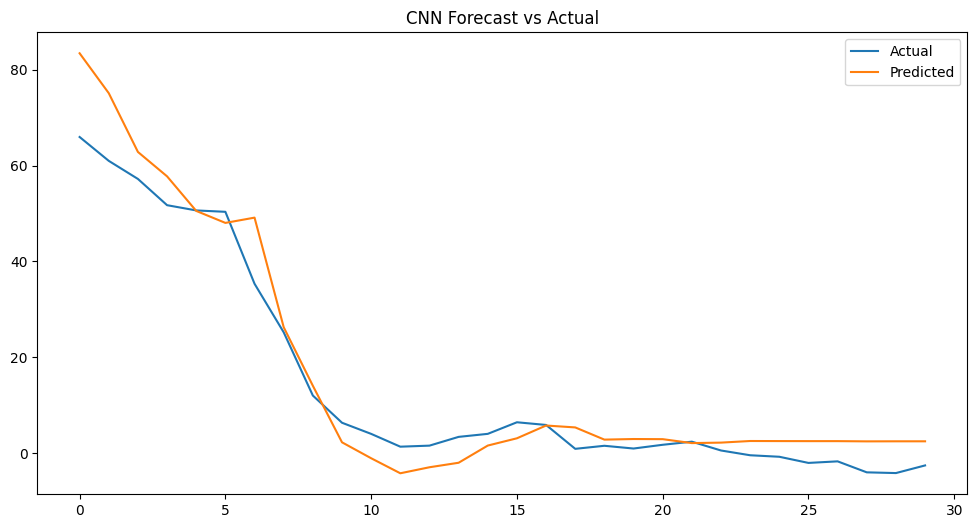

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 6  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 6), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 7

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 660kB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 09:06:56,752] A new study created in memory with name: no-name-bb1d7188-d78e-4a68-9175-14591fc94d2f
[I 2025-05-29 09:07:08,037] Trial 0 finished with value: 0.0029933043115306646 and parameters: {'filters': 108, 'kernel_size': 5, 'lr': 0.0013235683256970353, 'epochs': 37, 'batch_size': 16}. Best is trial 0 with value: 0.0029933043115306646.
[I 2025-05-29 09:07:18,120] Trial 1 finished with value: 0.00844366600116094 and parameters: {'filters': 33, 'kernel_size': 2, 'lr': 0.00044832394706146916, 'epochs': 38, 'batch_size': 32}. Best is trial 0 with value: 0.0029933043115306646.
[I 2025-05-29 09:07:29,945] Trial 2 finished with value: 0.00187714010826312 and parameters: {'filters': 64, 'kernel_size': 1, 'lr': 0.003657836673836905, 'epochs': 48, 'batch_size': 32}. Best is trial 2 with value: 0.00187714010826312.
[I 2025-05-29 09:07:40,764] Trial 3 finished with value: 0.0018896150480334957 and parameters: {'filters': 77, 'kernel_size': 3, 'lr': 0.005649650604590939, 'epochs'

Best trial: {'filters': 46, 'kernel_size': 3, 'lr': 0.006123129259625656, 'epochs': 43, 'batch_size': 8}
Epoch 1/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135
Epoch 2/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034     
Epoch 3/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 
Epoch 4/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 5/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 6/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 7/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Epoch 8/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 9/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 10/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6682e-04
Epoch 11/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7693e-04
Epoch 12/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7122e-04 
Epoch 13/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 14/43
34/34 ━━━━

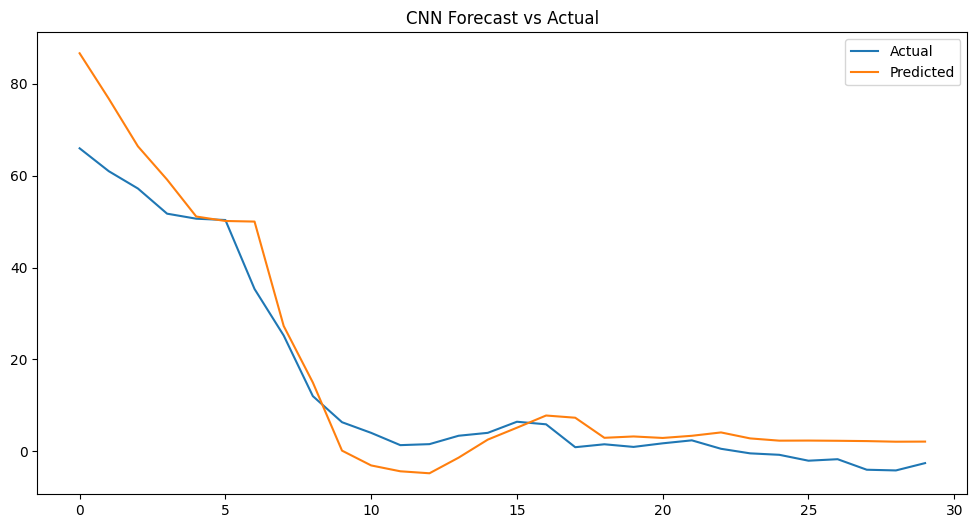

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 7  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 7), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 8

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 6.29MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 09:13:05,213] A new study created in memory with name: no-name-2058a6d6-392d-4b63-a588-8ef3b0698a7e
[I 2025-05-29 09:13:11,450] Trial 0 finished with value: 0.018768088969712455 and parameters: {'filters': 48, 'kernel_size': 5, 'lr': 0.00012400518563246394, 'epochs': 15, 'batch_size': 16}. Best is trial 0 with value: 0.018768088969712455.
[I 2025-05-29 09:13:22,873] Trial 1 finished with value: 0.0025927304717091224 and parameters: {'filters': 40, 'kernel_size': 4, 'lr': 0.002402306868936564, 'epochs': 47, 'batch_size': 32}. Best is trial 1 with value: 0.0025927304717091224.
[I 2025-05-29 09:13:30,696] Trial 2 finished with value: 0.002818715166843807 and parameters: {'filters': 85, 'kernel_size': 8, 'lr': 0.0018594720252261671, 'epochs': 21, 'batch_size': 16}. Best is trial 1 with value: 0.0025927304717091224.
[I 2025-05-29 09:13:36,135] Trial 3 finished with value: 0.0065418534019651515 and parameters: {'filters': 92, 'kernel_size': 6, 'lr': 0.0023652830116067097, 'epoc

Best trial: {'filters': 113, 'kernel_size': 1, 'lr': 0.00525789064050537, 'epochs': 36, 'batch_size': 8}
Epoch 1/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204
Epoch 2/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 3/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 4/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 5/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 6/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 7/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9399e-04
Epoch 8/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2836e-04
Epoch 9/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6662e-04
Epoch 10/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013     
Epoch 11/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 12/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6305e-04
Epoch 13/36
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5052e-04 
Epoch 14/36
34/34 ━━

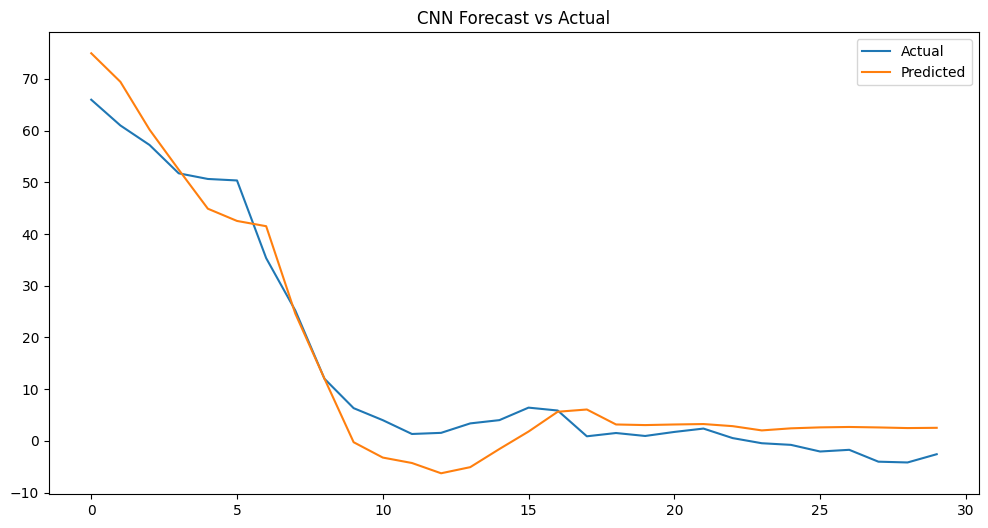

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 8  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 8), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 9

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 9.69MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-05-29 09:18:50,157] A new study created in memory with name: no-name-78ef8fde-41d1-40f5-a7c6-79651b9f86e1
[I 2025-05-29 09:18:59,249] Trial 0 finished with value: 0.007140389876440167 and parameters: {'filters': 124, 'kernel_size': 5, 'lr': 0.00018206327017310643, 'epochs': 26, 'batch_size': 8}. Best is trial 0 with value: 0.007140389876440167.
[I 2025-05-29 09:19:19,206] Trial 1 finished with value: 0.00235665284950907 and parameters: {'filters': 124, 'kernel_size': 1, 'lr': 0.0012229487777477778, 'epochs': 49, 'batch_size': 32}. Best is trial 1 with value: 0.00235665284950907.
[I 2025-05-29 09:19:26,439] Trial 2 finished with value: 0.007384931261185557 and parameters: {'filters': 94, 'kernel_size': 5, 'lr': 0.0016103595045749621, 'epochs': 16, 'batch_size': 32}. Best is trial 1 with value: 0.00235665284950907.
[I 2025-05-29 09:19:40,820] Trial 3 finished with value: 0.0046482532246348756 and parameters: {'filters': 40, 'kernel_size': 1, 'lr': 0.0002908313705495509, 'epochs':

Best trial: {'filters': 103, 'kernel_size': 7, 'lr': 0.00853936984651478, 'epochs': 50, 'batch_size': 8}
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160   
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9885e-04 
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1654e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4996e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6645e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8099e-04 
Epoch 14/50
33/33

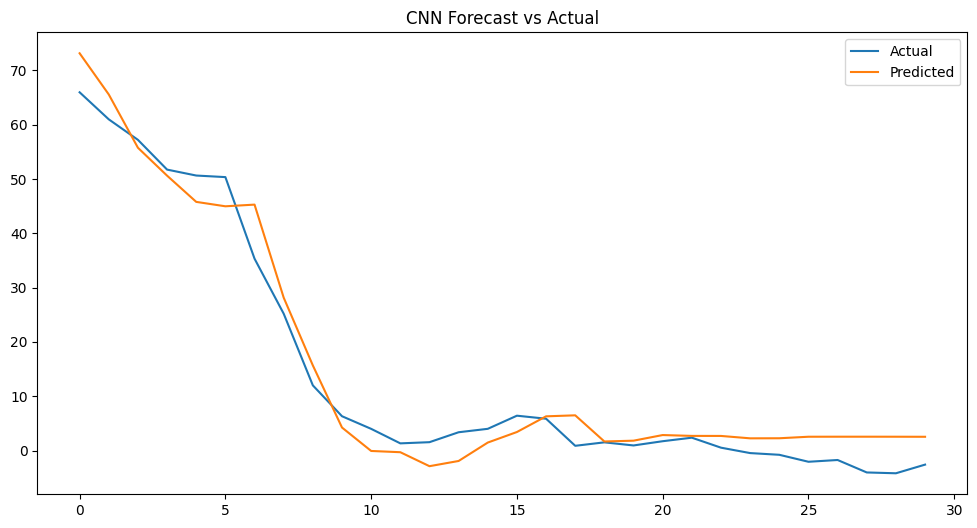

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown



# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 9  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 9), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()


